In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### MBP-10 is a Level 2 (L2) order book data feed that includes only the best 10 bid and ask prices, their sizes, and order counts. This is a standard practice because: 

- Most trades occur near the top of the book (best bid/ask prices).

- Data beyond 10 levels is often not critical for short-term trading strategies and would create large data overhead.

### Genereating of the Order Books 

In [ ]:
#Generate simulated order book for 3 tickers
def generate_order_book(ticker):
    np.random.seed(abs(hash(ticker)) % (10**7))  
    
    # Base price between $90 and $96
    base_price = np.random.uniform(90, 96)
    
    # Random increments for ask side 
    ask_increments = np.random.uniform(0.01, 0.1, 10)
    ask_prices = np.round(base_price + np.cumsum(ask_increments), 2)
    
    # Random increments for bid side 
    bid_increments = np.random.uniform(0.01, 0.1, 10)
    bid_prices = np.round(base_price - np.cumsum(bid_increments), 2)[::-1]
    
    # Adding slight random noise
    ask_prices += np.random.normal(0, 0.02, 10)
    bid_prices += np.random.normal(0, 0.02, 10)
    
    # Random sizes for orders
    ask_sizes = np.random.randint(50, 300, 10)
    bid_sizes = np.random.randint(50, 300, 10)
    
    return pd.DataFrame({
        'ticker': ticker,
        'ask_px': np.round(ask_prices, 2),
        'ask_sz': ask_sizes,
        'bid_px': np.round(bid_prices, 2),
        'bid_sz': bid_sizes
    })

# Generate for all tickers
tickers = ['TICKER1', 'TICKER2', 'TICKER3']
order_books = {t: generate_order_book(t) for t in tickers}

# Display order books
for t, ob in order_books.items():
    print(f"\n{t} Order Book:")
    print(ob)



TICKER1 Order Book:
    ticker  ask_px  ask_sz  bid_px  bid_sz
0  TICKER1   95.96      50   95.35     144
1  TICKER1   96.04     268   95.37      65
2  TICKER1   96.07      75   95.41     165
3  TICKER1   96.11      86   95.49     282
4  TICKER1   96.23     166   95.55     294
5  TICKER1   96.30     185   95.55     281
6  TICKER1   96.30      86   95.61     187
7  TICKER1   96.39      94   95.67     251
8  TICKER1   96.47      58   95.76      70
9  TICKER1   96.56     235   95.87     145

TICKER2 Order Book:
    ticker  ask_px  ask_sz  bid_px  bid_sz
0  TICKER2   94.15     279   93.63      55
1  TICKER2   94.14     119   93.65     217
2  TICKER2   94.27      54   93.76     151
3  TICKER2   94.32     137   93.79     110
4  TICKER2   94.33      72   93.79     154
5  TICKER2   94.34     138   93.85     256
6  TICKER2   94.42     140   93.94     155
7  TICKER2   94.39      97   93.95     142
8  TICKER2   94.45      79   93.99     152
9  TICKER2   94.50     105   94.02     250

TICKER3 Ord

Simulate an orderbook entry for calculating slippage.

### Function to calculate the price impact of a trade or slippage

In [ ]:
#Calculate temporary impact (slippage) for buying x shares from ask side.
def calculate_slippage(order_book, x):
    """
    Calculate temporary impact (slippage) for buying x shares from ask side.
    """
    ask_prices = order_book['ask_px'].values
    ask_sizes = order_book['ask_sz'].values

    shares_remaining = x
    cost = 0
    for price, size in zip(ask_prices, ask_sizes):
        shares_to_buy = min(size, shares_remaining)
        cost += shares_to_buy * price
        shares_remaining -= shares_to_buy
        if shares_remaining <= 0:
            break

    if shares_remaining > 0:
        # Not enough liquidity in the book to buy x shares
        cost += shares_remaining * ask_prices[-1]  # assume last level price

    avg_price = cost / x
    mid_price = (order_book['ask_px'].iloc[0] + order_book['bid_px'].iloc[0]) / 2
    slippage = avg_price - mid_price
    return slippage


### Simulating the Slippage

In [ ]:
# Simulating the slippage 
def simulate_all_tickers(order_books, max_x=30000, step=500):
    results = {}
    for ticker, df in order_books.items():
        x_values = list(range(step, max_x + step, step))
        g_values = [calculate_slippage(df, x) for x in x_values]
        results[ticker] = (x_values, g_values)
    return results

results = simulate_all_tickers(order_books)


### Fitting and plotting the result of the simulation of the quadratic model.

Fitted Model: g_t(x) = 0.3036 + 0.0003x + -0.000000x²


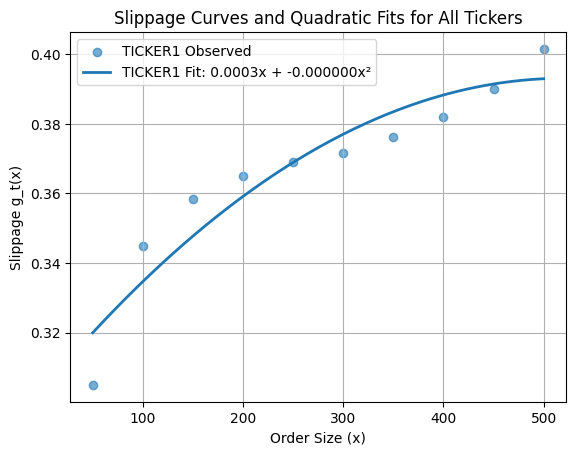

Fitted Model: g_t(x) = 0.2695 + -0.0001x + 0.000000x²


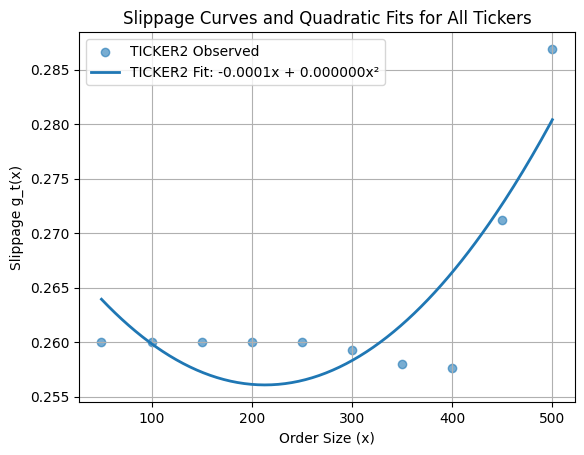

Fitted Model: g_t(x) = 0.2716 + -0.0000x + 0.000000x²


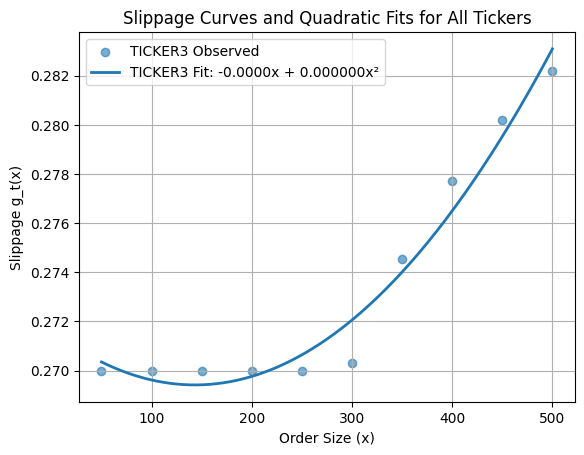

In [ ]:
# Fitting the Quadratic Model to Simulated Slippage Curves
def fit_quadratic(x, g):
    x = np.array(x_values)
    g = np.array(g_values)

    # Create matrix with columns [1, x, x^2]
    A = np.vstack([np.ones(len(x)), x, x**2]).T
    c, a, b = np.linalg.lstsq(A, g, rcond=None)[0]
    return c, a, b

for t in tickers:   
    x_values, g_values = simulate_slippage(order_books[t])
    c, a, b = fit_quadratic(x_values, g_values)
    print(f"Fitted Model: g_t(x) = {c:.4f} + {a:.4f}x + {b:.6f}x²")
    x_fit = np.linspace(min(x_values), max(x_values), 200)
    g_fit = c + a * x_fit + b * x_fit**2
        
    # Plot
    plt.scatter(x_values, g_values, label=f"{t} Observed", alpha=0.6)
    plt.plot(x_fit, g_fit, linewidth=2, label=f"{t} Fit: {a:.4f}x + {b:.6f}x²")
    plt.title("Slippage Curves and Quadratic Fits for All Tickers")
    plt.xlabel("Order Size (x)")
    plt.ylabel("Slippage g_t(x)")
    plt.grid(True)
    plt.legend()
    plt.show()